## Video Action Classification

In [1]:
import os
import pickle

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pad_packed_sequence, pack_sequence, pack_padded_sequence
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
%load_ext autoreload
%autoreload 2

dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device : {}".format(dev))

Using device : cuda:0


Load dataset

In [2]:
# pickle_filename = 'data.pickle'

# if os.path.isfile(pickle_filename):
#     with open(pickle_filename, 'rb') as file:
#         train_data_feat, train_data_labels, test_data_feat = pickle.load(file)
# else:
#     from read_datasetBreakfast import load_data, read_mapping_dict

#     COMP_PATH = ''

#     ''' 
#     training to load train set
#     test to load test set
#     '''
#     train_split =  os.path.join(COMP_PATH, 'splits/train.split1.bundle') #Train Split
#     test_split  =  os.path.join(COMP_PATH, 'splits/test.split1.bundle') #Test Split
#     GT_folder   =  os.path.join(COMP_PATH, 'groundTruth/') #Ground Truth Labels for each training video 
#     DATA_folder =  os.path.join(COMP_PATH, 'data/') #Frame I3D features for all videos
#     mapping_loc =  os.path.join(COMP_PATH, 'splits/mapping_bf.txt') 

#     actions_dict = read_mapping_dict(mapping_loc)
#     train_data_feat, train_data_labels = load_data( train_split, actions_dict, GT_folder, DATA_folder, datatype = "training") #Get features and labels
#     test_data_feat = load_data( test_split, actions_dict, GT_folder, DATA_folder, datatype = "test") #Get features only
    
#     with open(pickle_filename, 'wb') as file:
#         pickle.dump((train_data_feat, train_data_labels, test_data_feat), file)

# print(len(train_data_feat))
# print(len(train_data_labels))
# print(len(test_data_feat))

```python
print(len(train_data_feat))
print(len(train_data_labels))
print(len(test_data_feat))
> 1460
> 1460
> 252
```

Flatten dataset

In [3]:
# with open("training_segment.txt", 'r') as file:
#     training_segment = [[int(a) for a in line.split()] for line in file]

# # tot_segment_len = 0
# # n_segment_len = 0
# # max_segment_len = 0
# # min_segment_len = float("inf")

# train_feat_flat = []
# train_labels_flat = []
# train_flat_idx = []
# for video_idx, video_segments in enumerate(tqdm(training_segment)):
#     for i in range(len(video_segments)-1):
#         segment_len = video_segments[i+1] - video_segments[i]
# #         tot_segment_len += segment_len
# #         n_segment_len += 1
# #         if segment_len > max_segment_len:
# #             max_segment_len = segment_len
# #         if segment_len < min_segment_len:
# #             min_segment_len = segment_len
#         train_flat_idx.append(len(train_feat_flat))
#         train_feat_flat.extend(train_data_feat[video_idx][video_segments[i]:video_segments[i+1]])
#         train_labels_flat.extend([(train_data_labels[video_idx][i])-1]*segment_len)
# train_flat_idx.append(len(train_feat_flat))

# # avg_segment_len = tot_segment_len / n_segment_len
# # print(avg_segment_len, max_segment_len, min_segment_len)

```python
print(avg_segment_len, max_segment_len, min_segment_len)
> 404.3518021201413 5791 8
```

Pickle (or load) flatten dataset

In [4]:
num_split = 10
load_split = 10

files_exist = []
for i in range(num_split):
    pickle_filename = "flatten_data_{}.pickle".format(i)
    files_exist.append(os.path.isfile(pickle_filename))

if not all(files_exist):
    max_len = len(train_feat_flat)
    split_len = max_len//num_split
    for i in tqdm(range(num_split)):
        pickle_filename = "flatten_data_{}.pickle".format(i)
        start_idx = split_len*i
        end_idx = split_len*(i+1) if i < num_split-1 else max_len
        print(i, start_idx, end_idx)
        with open(pickle_filename, 'wb') as file:
            train_feat_split_tensor = torch.stack(train_feat_flat[start_idx:end_idx]).to(dtype=torch.float32)
            train_labels_split_tensor = torch.LongTensor(train_labels_flat[start_idx:end_idx])
            pickle.dump((train_feat_split_tensor, train_labels_split_tensor), file)
    with open("flatten_data_idx.txt", 'w') as file:
        for i in train_flat_idx:
            file.write("{} ".format(i))

train_feat_split_list = []
train_labels_split_list = []
for i in tqdm(range(load_split)):
    pickle_filename = "flatten_data_{}.pickle".format(i)
    with open(pickle_filename, 'rb') as file:
        train_feat_split, train_labels_split = pickle.load(file)
        train_feat_split_list.append(train_feat_split)
        train_labels_split_list.append(train_labels_split)
with open("flatten_data_idx.txt", 'r') as file:
    train_flat_idx = [int(a) for line in file for a in line.split()]

train_feat_tensor = torch.cat(train_feat_split_list, dim=0)
train_labels_tensor = torch.cat(train_labels_split_list, dim=0)
print(train_feat_tensor.shape)
print(train_labels_tensor.shape)
print(len(train_flat_idx))
print(train_flat_idx[:10])


torch.Size([2860789, 400])
torch.Size([2860789])
7076
[0, 260, 465, 793, 1054, 1687, 5923, 7216, 7288, 7338]


Define model

In [5]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.dropout1 = nn.Dropout(p=0.2)
        self.num_layers = 2
        self.lstm = nn.LSTM(400, 128, batch_first=True, num_layers=self.num_layers, dropout=0.5)
        self.dropout2 = nn.Dropout(p=0.5)
        self.linear = nn.Linear(128*(2+self.num_layers), 47)
        self.padding_value = 0
    def forward(self, x):
        x_pad, lengths = pad_packed_sequence(x, batch_first=True, padding_value=self.padding_value)
        x_pad = self.dropout1(x_pad)
        x = pack_padded_sequence(x_pad, lengths, batch_first=True, enforce_sorted=False)
        
        h, (h_last, c) = self.lstm(x)
        
        h_pad, lengths = pad_packed_sequence(h, batch_first=True, padding_value=self.padding_value)
        h_avg_pool = torch.sum(h_pad, 1) / (torch.sum((h_pad != self.padding_value), 1) + 1e-5)
        h_max_pool = torch.max(h_pad, 1)[0]
        x = torch.cat((*(h_last.unbind()), h_avg_pool, h_max_pool), 1)
        
        x = self.dropout2(x)
        
        x = self.linear(x)
        return x

model = Model()
for param in model.parameters():
    print(type(param.data), param.size())

<class 'torch.Tensor'> torch.Size([512, 400])
<class 'torch.Tensor'> torch.Size([512, 128])
<class 'torch.Tensor'> torch.Size([512])
<class 'torch.Tensor'> torch.Size([512])
<class 'torch.Tensor'> torch.Size([512, 128])
<class 'torch.Tensor'> torch.Size([512, 128])
<class 'torch.Tensor'> torch.Size([512])
<class 'torch.Tensor'> torch.Size([512])
<class 'torch.Tensor'> torch.Size([47, 512])
<class 'torch.Tensor'> torch.Size([47])


Define training routine

In [6]:
import time
import copy

import copy
def train_val(num_epoch, dataloader_dict, model, loss, optimizer, print_epoch=True, device=None):
    val_acc_history = []
    val_loss_history = []
    train_acc_history = []
    train_loss_history = []
    best_acc = 0.0
    best_model_weights = copy.deepcopy(model.state_dict())
    
    for epoch in range(num_epoch):
        since = time.time()
        if print_epoch:
            print("Epoch {}/{}".format(epoch+1, num_epoch))
            print("-----------")
        
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else :
                model.eval()
            total_loss = 0.0
            total_correct = 0.0
            for X, y, batch_len in dataloader_dict[phase]:
                if device is not None:
                    X = X.to(device)
                    y = y.to(device)
                with torch.set_grad_enabled(phase == "train"):
                    y_tilde = model(X)
                    L = loss(y_tilde, y)
                    if phase == "train":
                        optimizer.zero_grad()
                        L.backward()
                        optimizer.step()
                y_tilde_label = torch.argmax(y_tilde, dim=1)
                num_correct = torch.sum((y_tilde_label == y))
                
                total_loss += L.item() * batch_len
                total_correct += num_correct.item()
            
            epoch_loss = total_loss / len(dataloader_dict[phase].dataset)
            epoch_acc = (total_correct / len(dataloader_dict[phase].dataset)) * 100
            
            if phase == "val":
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc)
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_weights = copy.deepcopy(model.state_dict())
            if phase == "train":
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc)

            if print_epoch:
                print("{} | Loss : {:.4f}  Acc : {:.2f}%".format(phase.capitalize().ljust(5), epoch_loss, epoch_acc))
        
        print("Time elapsed : {:.2f} s".format(time.time() - since))
        print()
    
    model.load_state_dict(best_model_weights)
    return model, (val_acc_history, val_loss_history, train_acc_history, train_loss_history)

Create dataset

In [7]:
from torch.utils.data import Dataset, DataLoader, Subset
from torch._utils import _accumulate

class MyDataset(Dataset):
    
    def __init__(self, features, labels, indices):
        self.features = features
        self.labels = labels
        self.indices = indices
        self.len = len(self.indices) - 1

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return (self.features[self.indices[idx]:self.indices[idx+1]], self.labels[self.indices[idx]])

my_dataset = MyDataset(train_feat_tensor, train_labels_tensor, train_flat_idx)

Split dataset

In [8]:
tot_len = len(my_dataset)
print("Number of training data: {}".format(tot_len))

train_split_size = 0.8
lengths = [int(tot_len*train_split_size), tot_len - int(tot_len*train_split_size)]

train_dataset, val_dataset = torch.utils.data.random_split(my_dataset, lengths)

Number of training data: 7075


Create DataLoader

In [9]:
def collate(batch_data):
    features = []
    labels = []
    for feature, label in batch_data:
        features.append(feature)
        labels.append(label)
    return (pack_sequence(features, enforce_sorted=False), torch.tensor(labels), len(batch_data))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True, collate_fn=collate)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, pin_memory=True, collate_fn=collate)

Start training

In [10]:
my_model = Model()
my_model.to(dev)
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(my_model.parameters())

trained_model, acc = train_val(100, {"train": train_loader, "val": val_loader}, my_model, loss, optimizer, device=dev)

Epoch 1/100
-----------
Train | Loss : 3.2567  Acc : 14.91%
Val   | Loss : 2.7268  Acc : 26.29%
Time elapsed : 80.78 s

Epoch 2/100
-----------
Train | Loss : 2.6755  Acc : 25.07%
Val   | Loss : 2.6351  Acc : 28.83%
Time elapsed : 80.09 s

Epoch 3/100
-----------
Train | Loss : 2.4551  Acc : 28.73%
Val   | Loss : 2.2872  Acc : 35.62%
Time elapsed : 80.11 s

Epoch 4/100
-----------
Train | Loss : 2.2025  Acc : 34.70%
Val   | Loss : 2.1054  Acc : 39.22%
Time elapsed : 79.83 s

Epoch 5/100
-----------
Train | Loss : 2.0291  Acc : 38.45%
Val   | Loss : 1.9384  Acc : 44.52%
Time elapsed : 78.30 s

Epoch 6/100
-----------
Train | Loss : 1.8824  Acc : 42.40%
Val   | Loss : 1.8193  Acc : 44.10%
Time elapsed : 79.05 s

Epoch 7/100
-----------
Train | Loss : 1.7919  Acc : 44.86%
Val   | Loss : 1.7488  Acc : 48.62%
Time elapsed : 78.54 s

Epoch 8/100
-----------
Train | Loss : 1.7010  Acc : 46.86%
Val   | Loss : 1.6602  Acc : 50.81%
Time elapsed : 79.57 s

Epoch 9/100
-----------
Train | Loss : 1

Train | Loss : 0.4286  Acc : 85.60%
Val   | Loss : 1.3273  Acc : 63.82%
Time elapsed : 78.88 s

Epoch 70/100
-----------
Train | Loss : 0.3280  Acc : 88.89%
Val   | Loss : 1.2696  Acc : 66.78%
Time elapsed : 82.26 s

Epoch 71/100
-----------
Train | Loss : 0.3808  Acc : 86.59%
Val   | Loss : 1.2982  Acc : 66.15%
Time elapsed : 81.15 s

Epoch 72/100
-----------
Train | Loss : 0.5468  Acc : 82.31%
Val   | Loss : 1.4430  Acc : 61.63%
Time elapsed : 85.39 s

Epoch 73/100
-----------
Train | Loss : 0.4537  Acc : 84.81%
Val   | Loss : 1.2607  Acc : 66.36%
Time elapsed : 84.62 s

Epoch 74/100
-----------
Train | Loss : 0.3427  Acc : 87.70%
Val   | Loss : 1.2699  Acc : 67.56%
Time elapsed : 83.70 s

Epoch 75/100
-----------
Train | Loss : 0.3552  Acc : 87.95%
Val   | Loss : 1.2860  Acc : 64.73%
Time elapsed : 84.47 s

Epoch 76/100
-----------
Train | Loss : 0.3503  Acc : 88.16%
Val   | Loss : 1.2505  Acc : 67.00%
Time elapsed : 86.98 s

Epoch 77/100
-----------
Train | Loss : 0.3551  Acc : 87.

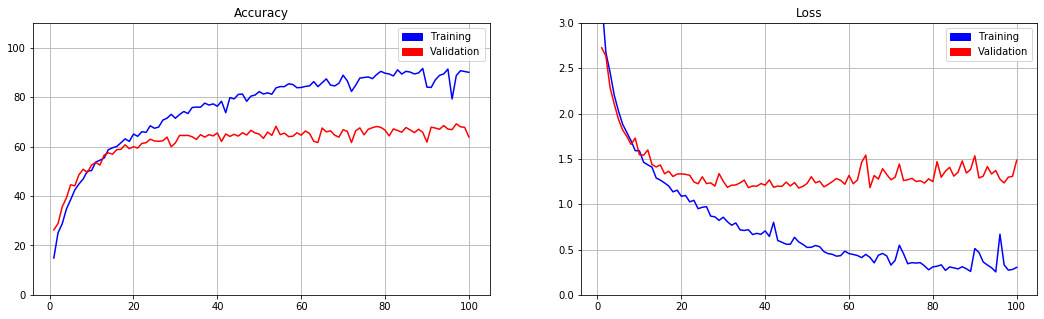

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.figure(figsize=(18, 5))
epoch_num = range(1, 101)
plt.subplot(1, 2, 1)
plt.title('Accuracy')
plt.ylim(0, 110)
plt.grid(True)
plt.plot(epoch_num, acc[2], color="blue")
plt.plot(epoch_num, acc[0], color="red")
blue_patch = mpatches.Patch(color='blue', label='Training')
red_patch = mpatches.Patch(color='red', label='Validation')
plt.legend(handles=[blue_patch, red_patch])
plt.subplot(1, 2, 2)
plt.title('Loss')
plt.ylim(0, 3)
plt.grid(True)
plt.plot(epoch_num, acc[3], color="blue")
plt.plot(epoch_num, acc[1], color="red")
blue_patch = mpatches.Patch(color='blue', label='Training')
red_patch = mpatches.Patch(color='red', label='Validation')
plt.legend(handles=[blue_patch, red_patch])

In [13]:
print(max(acc[0]))

69.18727915194346


In [12]:
# optimizer = optim.Adam(my_model.parameters(), lr=0.00001)
# trained_model_tuning, acc_tuning = train_val(50, {"train": train_loader, "val": val_loader}, trained_model, loss, optimizer, device=dev)